## Machine Learning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
from scipy.stats import randint
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
import math

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

D:\Users\Damien\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
data_cleaned = pd.read_csv(r"C:\Users\Damien\Desktop\Data Scientist\P4\Dataset\seattle_dataset.csv")

In [3]:
data_cleaned.head(5)

,Unnamed: 0,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,GHGEmissionsIntensity,Latitude,Longitude,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,PropertyGFATotal_log,Energy_rate,GHG_rate,Age,Parking
0,0,1,2016,NonResidential,Hotel,DOWNTOWN,1927,1.0,12.0,88434,...,2.83,47.61220,-122.33799,15.793246,5.521381,11.390012,1.386587,0.484756,89,0
1,1,2,2016,NonResidential,Hotel,DOWNTOWN,1996,1.0,11.0,103566,...,2.86,47.61317,-122.33393,15.942305,5.689886,11.547964,1.380529,0.492718,20,1
2,2,3,2016,NonResidential,Hotel,DOWNTOWN,1969,1.0,41.0,956110,...,2.19,47.61393,-122.33810,18.100297,7.644575,13.770628,1.314413,0.555136,47,1
3,3,5,2016,NonResidential,Hotel,DOWNTOWN,1926,1.0,10.0,61320,...,4.67,47.61412,-122.33664,15.731636,5.657494,11.023861,1.427053,0.513204,90,0
4,4,8,2016,NonResidential,Hotel,DOWNTOWN,1980,1.0,18.0,175580,...,2.88,47.61375,-122.34047,16.466822,6.224578,12.075850,1.363616,0.515457,36,1


<AxesSubplot:>

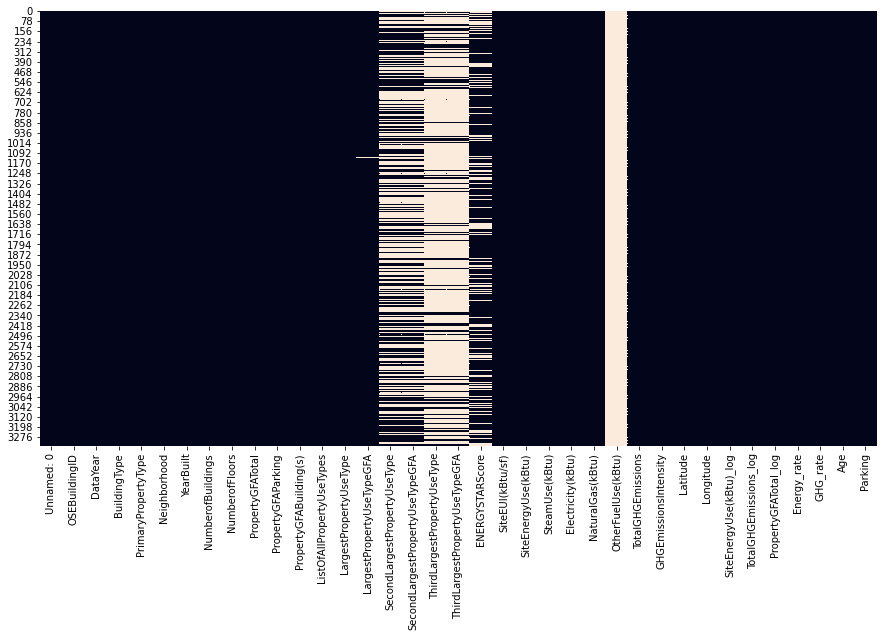

In [4]:
plt.figure(figsize=(15,8))
sns.heatmap(data_cleaned.isna(), cbar=False)

### PCA

In [5]:
pca_df = data_cleaned.reset_index()

n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data = pca_df[['PropertyGFATotal', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking']]

X = data.values
features = data.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

In [6]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

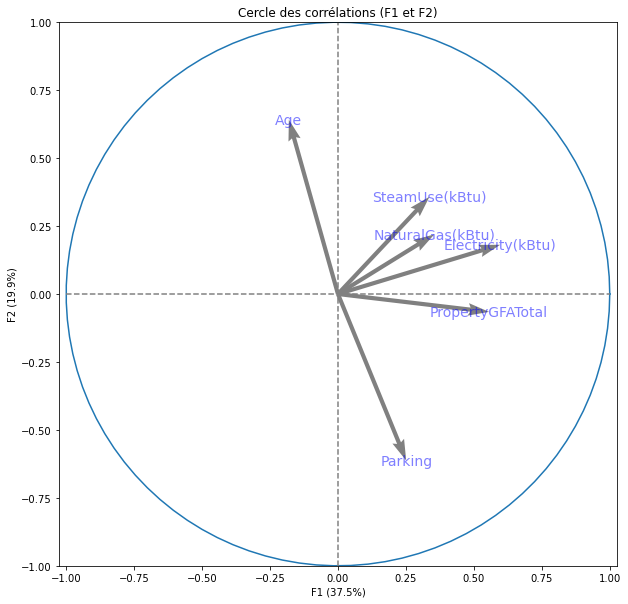

In [7]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

F1 (37.5%) : Electricité et Superficie   F2 (19.9%) : Age, Parking et Steam => 57.4% de variance expliquée

### Prediction de la consommation d'energie

#### Dummy Regressor

In [8]:
# Premier test avec boolean parking, steam, elec gaz, gfa_log age et target=energy_log
X = data_cleaned.loc[:, ['PropertyGFATotal_log', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking']]
y = data_cleaned.loc[:, ['SiteEnergyUse(kBtu)_log']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [9]:
from sklearn.dummy import DummyRegressor

# Estimator
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(X_train, y_train)
model_dummy.score(X_test, y_test)

-0.037309262559868994

In [10]:
# Creation d'une fonction de prédiction de la consommation en fonction du model
def conso(model, GFA=60000, Steam=10000000, Elec=2000000, Gas=4000000, Age=25, Pkg=0):
    X = np.array([GFA, Steam, Elec, Gas, Age, Pkg]).reshape(1,6)
    print(model.predict(X))

In [11]:
conso(model_dummy)

[14.41065081]


#### Linear Regressor

In [12]:
from sklearn.linear_model import LinearRegression

# Estimator
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
model_LR.score(X_test, y_test)

0.5803015338038907

In [13]:
conso(model_LR)

[[50419.65743158]]


#### SGDRegressor avec Transfomer

In [14]:
# Transformer
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

# Estimator
model_SGDR = SGDRegressor()
model_SGDR.fit(X_train_transformed, y_train.values.ravel())

# Test
model_SGDR.score(X_test_transformed, y_test)

0.6887392515542003

#### Avec des Pipelines

In [15]:
# Standard Scaler et Regression
model_SGDR_SS = make_pipeline(StandardScaler(),
                        SGDRegressor())

model_SGDR_SS.fit(X_train, y_train.values.ravel())
model_SGDR_SS.score(X_test, y_test)

0.6613926197641342

In [16]:
# PolynomialFeatures et Regression
model_SGDR_PF = make_pipeline(PolynomialFeatures(),
                        SGDRegressor())

model_SGDR_PF.fit(X_train, y_train.values.ravel())
model_SGDR_PF.score(X_test, y_test)

-3.5573490729644613e+80

#### On ajoute GridSearchCV pour evaluer les meilleurs Transformer/Estimator

In [17]:
# PolynomialFeatures et Regression
model_GS_CV1 = make_pipeline(PolynomialFeatures(),
                         StandardScaler(),
                         SGDRegressor())

params = {
    'polynomialfeatures__degree' : [1, 2, 3, 4],
    'sgdregressor__penalty' : ['l1', 'l2']
}

grid = GridSearchCV(model_GS_CV1, param_grid=params)

grid.fit(X_train, y_train.values.ravel())

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('sgdregressor', SGDRegressor())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                         'sgdregressor__penalty': ['l1', 'l2']})

In [18]:
grid.best_params_

{'polynomialfeatures__degree': 1, 'sgdregressor__penalty': 'l2'}

In [19]:
grid.score(X_test, y_test)

0.6071920909121719

#### Random Forest

In [20]:
# Transformer
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

# Estimator
Random_Forest = RandomForestRegressor()              

params = {
    'n_estimators' : [5,10,20,50,100],
    'min_samples_leaf' : [1,3,5,10], 
    'max_features': ['auto', 'sqrt']
}


gridRF = GridSearchCV(Random_Forest, param_grid=params)
gridRF.fit(X_train_transformed, y_train.values.ravel())

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [5, 10, 20, 50, 100]})

In [21]:
gridRF.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}

In [22]:
# Estimator best
Random_Forest_best = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, max_features='auto')
Random_Forest_best.fit(X_train_transformed, y_train.values.ravel())

RandomForestRegressor()

In [23]:
# Test
Random_Forest_best.score(X_test_transformed, y_test.values.ravel())

0.6366340686776739

#### RMSE AMSE, r², neg_rlmse

In [24]:
#AMSE
print(mean_absolute_error(y_test, model_LR.predict(X_test_transformed)))

#RMSE
print(mean_squared_error(y_test, model_LR.predict(X_test_transformed)))

9.53107655689437
91.37297045719183


In [25]:
# Création d'une fonction d'évaluation de performance des modèles
def modeles_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred)
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("MAPE: ", mape.round(5))
    print("R²: ", r_score.round(5))

In [26]:
modeles_metrics(y_test, model_SGDR.predict(X_test_transformed))

MAE:  0.4992
MSE:  0.45709
RMSE:  0.6760844084395934
MAPE:  0.03401
R²:  0.68874


#### On regroupe les performance des modèles dans un DataFrame

In [27]:
import time
model_ridge = Ridge()
model_lasso = Lasso()

In [28]:
model = [model_dummy, model_LR, model_SGDR, model_ridge, model_lasso, Random_Forest_best]
dict_model = {}

for model in model:
    start = time.time()
    model.fit(X_train_transformed, y_train.values.ravel())
    end = time.time()
    y_pred = model.predict(X_test_transformed)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred)
    duree = end-start
    dict_model[model] = (mae, mse, mape, rmse, r_score, duree)

df_eval_model = pd.DataFrame(dict_model, index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'DUREE'])
df_eval_model.columns = ['Dummy Regressor', 'Linear Regression', 'SGDRegressor', 'Ridge', 'Lasso', 'RandomForestRegressor']

df_eval_model.transpose()

,MAE,MSE,RMSE,MAPE,R²,DUREE
Dummy Regressor,0.929080,1.523301,0.061709,1.234221,-0.037309,0.000000
Linear Regression,0.504014,0.459631,0.034352,0.677961,0.687009,0.000974
SGDRegressor,0.503803,0.462677,0.034319,0.680203,0.684935,0.003001
Ridge,0.504085,0.459694,0.034357,0.678007,0.686966,0.000000
Lasso,0.935554,1.474449,0.062829,1.214269,-0.004043,0.000000
RandomForestRegressor,0.587079,0.534242,0.041721,0.730918,0.636202,0.524051


<function matplotlib.pyplot.show(close=None, block=None)>

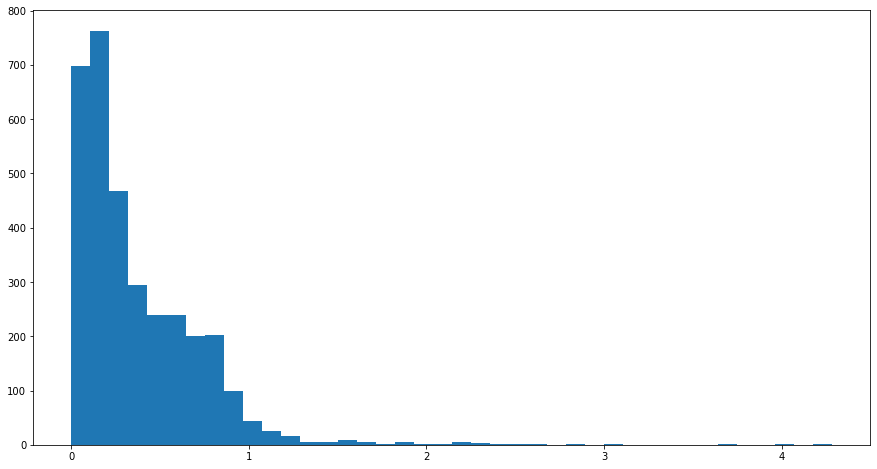

In [29]:
# histogramme des erreus RF
plt.figure(figsize=(15,8))
err_hist = np.abs(y - Random_Forest_best.predict(scaler.fit_transform(X)).reshape(3344,1))
plt.hist(err_hist, bins=40)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

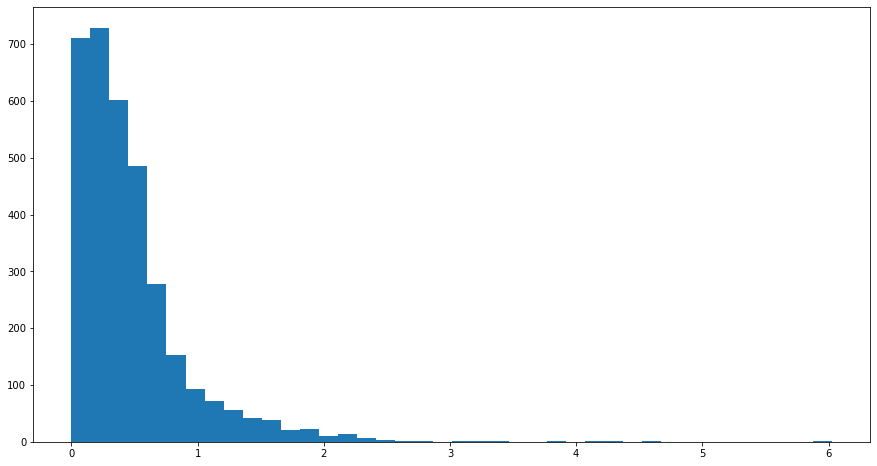

In [30]:
# histogramme des erreus LR
plt.figure(figsize=(15,8))
err_hist = np.abs(y - model_LR.predict(scaler.fit_transform(X)).reshape(3344,1))
plt.hist(err_hist, bins=40)
plt.show

In [31]:
from sklearn.model_selection import cross_val_score

cross_val_score(Random_Forest_best, scaler.fit_transform(X), y.values.ravel(), cv=3, scoring='neg_mean_absolute_error')

array([-0.07267454, -0.03483487, -0.03227409])

In [32]:
cross_val_score(model_LR, scaler.fit_transform(X), y.values.ravel(), cv=3, scoring='neg_mean_absolute_error')

array([-0.53743229, -0.47280356, -0.44992129])

**Le modèle ensembliste RandomForest semble meilleur. Les modèles linéaires (Linear regression, SGDRegression, Ridge) reste acceptables. Essayons avec plus de features**

#### Modeles avec encodage des variables qualitatives et plus de features

In [33]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder 
from sklearn.compose import make_column_transformer

In [34]:
y2 = data_cleaned['SiteEnergyUse(kBtu)_log']
X2 = data_cleaned.loc[:, ['PropertyGFATotal_log', 'BuildingType', 'PrimaryPropertyType', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking', 'NumberofFloors', 'NumberofBuildings']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

In [35]:
numerical_features = ['PropertyGFATotal_log', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking', 'NumberofFloors', 'NumberofBuildings']
categorical_features = ['BuildingType', 'PrimaryPropertyType']

In [36]:
numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OrdinalEncoder())

In [37]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                       (categorical_pipeline, categorical_features))

In [38]:
X_train2_transformed = preprocessor.fit_transform(X_train2)
X_test2_transformed = preprocessor.fit_transform(X_test2)

In [39]:
model_LR.fit(X_train2_transformed, y_train2)

LinearRegression()

In [40]:
model_LR.score(X_test2_transformed, y_test2)

0.6984713135761904

In [41]:
model = [model_dummy, model_LR, model_SGDR, model_ridge, model_lasso, Random_Forest_best]
dict_model = {}

for model in model:
    start = time.time()
    model.fit(X_train2_transformed, y_train2.values.ravel())
    end = time.time()
    y_pred2 = model.predict(X_test2_transformed)
    mae = mean_absolute_error(y_test2, y_pred2)
    mse = mean_squared_error(y_test2, y_pred2)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test2, y_pred2)
    r_score = r2_score(y_test2, y_pred2)
    duree = end-start
    dict_model[model] = (mae, mse, mape, rmse, r_score, duree)

df_eval_model = pd.DataFrame(dict_model, index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'DUREE'])
df_eval_model.columns = ['Dummy Regressor', 'Linear Regression', 'SGDRegressor', 'Ridge', 'Lasso', 'RandomForestRegressor']

df_eval_model.transpose()

,MAE,MSE,RMSE,MAPE,R²,DUREE
Dummy Regressor,0.922637,1.422429,0.062303,1.192656,-0.012081,0.000000
Linear Regression,0.485491,0.423784,0.033749,0.650987,0.698471,0.000998
SGDRegressor,0.521802,0.498409,0.036708,0.705981,0.645374,0.006007
Ridge,0.485498,0.423777,0.033750,0.650982,0.698476,0.001020
Lasso,0.939433,1.407197,0.064209,1.186254,-0.001243,0.000997
RandomForestRegressor,0.479355,0.376653,0.034608,0.613720,0.732006,0.673229


L'ajout des variables qualitatives et de features supplémentaires améliore grandement les modèles linéaires de regression, mais perturbe le random forest.

#### Modeles sans encodage des variables qualitatives et plus de features

In [42]:
y3 = data_cleaned['SiteEnergyUse(kBtu)_log']
X3 = data_cleaned.loc[:, ['PropertyGFATotal_log', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking', 'NumberofFloors', 'NumberofBuildings']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2)

In [43]:
X_train3_transformed = scaler.fit_transform(X_train3)
X_test3_transformed = scaler.fit_transform(X_test3)

In [44]:
model = [model_dummy, model_LR, model_SGDR, model_ridge, model_lasso, Random_Forest_best]
dict_model = {}

for model in model:
    start = time.time()
    model.fit(X_train3_transformed, y_train3.values.ravel())
    end = time.time()
    y_pred3 = model.predict(X_test3_transformed)
    mae = mean_absolute_error(y_test3, y_pred3)
    mse = mean_squared_error(y_test3, y_pred3)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test3, y_pred3)
    r_score = r2_score(y_test3, y_pred3)
    duree = end-start
    dict_model[model] = (mae, mse, mape, rmse, r_score, duree)

df_eval_model = pd.DataFrame(dict_model, index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'DUREE'])
df_eval_model.columns = ['Dummy Regressor', 'Linear Regression', 'SGDRegressor', 'Ridge', 'Lasso', 'RandomForestRegressor']

df_eval_model.transpose()

,MAE,MSE,RMSE,MAPE,R²,DUREE
Dummy Regressor,0.911331,1.437027,0.061870,1.198761,-0.005370,0.000000
Linear Regression,0.485928,0.459839,0.034166,0.678114,0.678289,0.001026
SGDRegressor,0.484251,0.455936,0.034053,0.675230,0.681019,0.003994
Ridge,0.485977,0.459866,0.034169,0.678134,0.678270,0.000997
Lasso,0.936088,1.434208,0.064256,1.197584,-0.003397,0.000998
RandomForestRegressor,0.464240,0.388014,0.033927,0.622907,0.728539,0.604383


#### SelectKBest

In [45]:
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

In [46]:
y=y.astype('int')
chi2(X3, y)

(array([1.41929222e+02, 5.77292978e+10, 7.70772925e+10, 4.43163259e+10,
        2.25406904e+03, 2.87217435e+02, 4.69847474e+03, 1.56257009e+02]),
 array([1.69526682e-25, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.80223103e-56, 0.00000000e+00, 1.91763220e-28]))

In [47]:
selector = SelectKBest(chi2, k=3)
selector.fit_transform(X3, y)
selector.get_support()

array([False,  True,  True,  True, False, False, False, False])

In [48]:
#X2 : 'PropertyGFATotal_log', 'BuildingType', 'PrimaryPropertyType', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking', 'NumberofFloors', 'NumberofBuildings'
selector2 = SelectFromModel(model_LR)
selector2.fit_transform(X3, y.values.ravel())
selector2.get_support()

array([ True, False, False, False, False, False, False, False])

In [49]:
selector2.estimator_.coef_

array([ 8.99913349e-01, -3.45757557e-09,  2.53198286e-08,  1.34735815e-08,
        2.46374635e-03,  1.26655096e-01, -7.24893794e-03,  1.69389021e-02])

In [50]:
# Pour le RandomForest
gridRF.best_estimator_.feature_importances_

array([1.28415292e-03, 6.05759775e-03, 8.34474098e-01, 1.56845477e-01,
       1.01374812e-03, 3.24926524e-04])

#### Leanring Curve

In [51]:
from sklearn.model_selection import learning_curve

In [52]:
X2 = preprocessor.fit_transform(X2)
X_train2 = preprocessor.fit_transform(X_train2)

[ 642  672  703  733  764  794  825  855  886  917  947  978 1008 1039
 1070 1100 1131 1161 1192 1222 1253 1284 1314 1345 1375 1406 1436 1467
 1498 1528 1559 1589 1620 1650 1681 1712 1742 1773 1803 1834 1864 1895
 1925 1956 1987 2017 2048 2078 2109 2140]


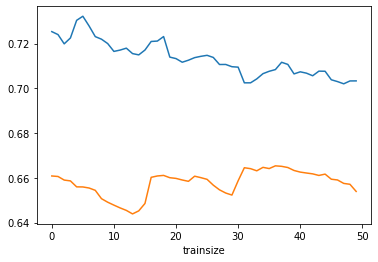

In [53]:
N, train_score, val_score = learning_curve(model_LR, X_train2_transformed, y_train2, train_sizes = np.linspace(0.3, 1, 50), cv=5)

print(N)
plt.plot(train_score.mean(axis=1), label='train')
plt.plot(val_score.mean(axis=1), label='validation')
plt.xlabel('trainsize')
plt.show()

[ 428  462  497  532  567  602  637  672  707  742  777  812  847  882
  917  952  987 1021 1056 1091 1126 1161 1196 1231 1266 1301 1336 1371
 1406 1441 1476 1511 1546 1580 1615 1650 1685 1720 1755 1790 1825 1860
 1895 1930 1965 2000 2035 2070 2105 2140]


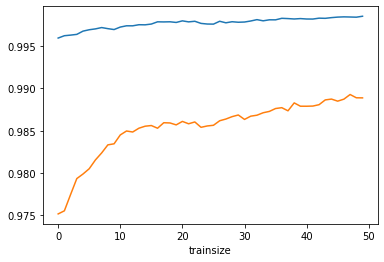

In [54]:
N, train_score, val_score = learning_curve(Random_Forest, X_train2_transformed, y_train2.values.ravel(), train_sizes = np.linspace(0.2, 1, 50), cv=5)

print(N)
plt.plot(train_score.mean(axis=1), label='train')
plt.plot(val_score.mean(axis=1), label='validation')
plt.xlabel('trainsize')
plt.show()

### Prediction des emissions de CO2 avec et sans Energy Star Score

#### Sans Energy star score avec encodage des variables qualitatives + features additionelles

In [55]:
data_cleaned_starS = data_cleaned.dropna(subset=['ENERGYSTARScore'])

In [56]:
y4 = data_cleaned_starS.loc[:, ['TotalGHGEmissions_log']]
X4 = data_cleaned_starS.loc[:, ['PropertyGFATotal_log', 'BuildingType', 'PrimaryPropertyType', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking', 'NumberofFloors', 'NumberofBuildings']]

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4,y4, test_size=0.2)

In [57]:
X_train4_transformed = preprocessor.fit_transform(X_train4)
X_test4_transformed = preprocessor.fit_transform(X_test4)

In [58]:
model = [model_dummy, model_LR, model_SGDR, model_ridge, model_lasso, Random_Forest_best]
dict_model = {}

for model in model:
    start = time.time()
    model.fit(X_train4_transformed, y_train4.values.ravel())
    end = time.time()
    y_pred4 = model.predict(X_test4_transformed)
    mae = mean_absolute_error(y_test4, y_pred4)
    mse = mean_squared_error(y_test4, y_pred4)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test4, y_pred4)
    r_score = r2_score(y_test4, y_pred4)
    duree = end-start
    dict_model[model] = (mae, mse, mape, rmse, r_score, duree)

df_eval_model = pd.DataFrame(dict_model, index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'DUREE'])
df_eval_model.columns = ['Dummy Regressor', 'Linear Regression', 'SGDRegressor', 'Ridge', 'Lasso', 'RandomForestRegressor']

df_eval_model.transpose()

,MAE,MSE,RMSE,MAPE,R²,DUREE
Dummy Regressor,1.211348,2.038023,0.527627,1.427594,-0.001696,0.000997
Linear Regression,0.832136,0.981200,0.349957,0.990555,0.517737,0.000969
SGDRegressor,0.857802,1.089124,0.387967,1.043611,0.464691,0.003019
Ridge,0.832193,0.981171,0.350015,0.990541,0.517751,0.000000
Lasso,1.211132,2.036605,0.525499,1.427097,-0.000999,0.000998
RandomForestRegressor,1.251628,2.894572,0.539428,1.701344,-0.422693,0.506084


#### Sans Energy star score avec features additionelles

In [59]:
y5 = data_cleaned_starS['TotalGHGEmissions_log']
X5 = data_cleaned_starS.loc[:, ['PropertyGFATotal_log', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking', 'NumberofFloors', 'NumberofBuildings']]

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2)

In [60]:
X_train5_transformed = scaler.fit_transform(X_train5)
X_test5_transformed = scaler.fit_transform(X_test5)

In [61]:
model = [model_dummy, model_LR, model_SGDR, model_ridge, model_lasso, Random_Forest_best]
dict_model = {}

for model in model:
    start = time.time()
    model.fit(X_train5_transformed, y_train5.values.ravel())
    end = time.time()
    y_pred5 = model.predict(X_test5_transformed)
    mae = mean_absolute_error(y_test5, y_pred5)
    mse = mean_squared_error(y_test5, y_pred5)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test5, y_pred5)
    r_score = r2_score(y_test5, y_pred5)
    duree = end-start
    dict_model[model] = (mae, mse, mape, rmse, r_score, duree)

df_eval_model = pd.DataFrame(dict_model, index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'DUREE'])
df_eval_model.columns = ['Dummy Regressor', 'Linear Regression', 'SGDRegressor', 'Ridge', 'Lasso', 'RandomForestRegressor']

df_eval_model.transpose()

,MAE,MSE,RMSE,MAPE,R²,DUREE
Dummy Regressor,1.164911,1.916797,0.453864,1.384484,-0.001384,0.000000
Linear Regression,0.744629,0.754421,0.279480,0.868574,0.605871,0.000998
SGDRegressor,0.759188,0.789638,0.280811,0.888616,0.587473,0.001995
Ridge,0.744693,0.754457,0.279539,0.868595,0.605852,0.000000
Lasso,1.164862,1.915672,0.452233,1.384078,-0.000797,0.000000
RandomForestRegressor,1.268272,2.741208,0.493395,1.655659,-0.432078,0.452278


#### Sans Energy star score

In [62]:
y6 = data_cleaned_starS['TotalGHGEmissions_log']
X6 = data_cleaned_starS.loc[:, ['PropertyGFATotal_log', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking']]

X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.2)

In [63]:
X_train6_transformed = scaler.fit_transform(X_train6)
X_test6_transformed = scaler.fit_transform(X_test6)

In [64]:
model = [model_dummy, model_LR, model_SGDR, model_ridge, model_lasso, Random_Forest_best]
dict_model = {}

for model in model:
    start = time.time()
    model.fit(X_train6_transformed, y_train6.values.ravel())
    end = time.time()
    y_pred6 = model.predict(X_test6_transformed)
    mae = mean_absolute_error(y_test6, y_pred6)
    mse = mean_squared_error(y_test6, y_pred6)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test6, y_pred6)
    r_score = r2_score(y_test6, y_pred6)
    duree = end-start
    dict_model[model] = (mae, mse, mape, rmse, r_score, duree)

df_eval_model = pd.DataFrame(dict_model, index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'DUREE'])
df_eval_model.columns = ['Dummy Regressor', 'Linear Regression', 'SGDRegressor', 'Ridge', 'Lasso', 'RandomForestRegressor']

df_eval_model.transpose()

,MAE,MSE,RMSE,MAPE,R²,DUREE
Dummy Regressor,1.197276,2.097080,0.622846,1.448130,-0.000791,0.000000
Linear Regression,0.801562,0.902413,0.411882,0.949954,0.569341,0.000000
SGDRegressor,0.859235,1.032060,0.437118,1.015904,0.507469,0.001970
Ridge,0.801559,0.902295,0.411943,0.949892,0.569397,0.000000
Lasso,1.196925,2.095913,0.619477,1.447727,-0.000234,0.000000
RandomForestRegressor,1.350272,3.174001,0.563123,1.781573,-0.514731,0.399021


#### Avec Energy star score

In [65]:
y7 = data_cleaned_starS.loc[:, ['TotalGHGEmissions_log']]
X7 = data_cleaned_starS.loc[:, ['PropertyGFATotal_log', 'BuildingType', 'PrimaryPropertyType', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking', 'NumberofFloors', 'NumberofBuildings', 'ENERGYSTARScore']]

X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, test_size=0.2)

In [66]:
numerical_features2 = ['PropertyGFATotal_log', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Age', 'Parking', 'NumberofFloors', 'NumberofBuildings', 'ENERGYSTARScore']
categorical_features2 = ['BuildingType', 'PrimaryPropertyType']

In [67]:
preprocessor2 = make_column_transformer((numerical_pipeline, numerical_features2),
                       (categorical_pipeline, categorical_features2))

In [68]:
X_train7_transformed = preprocessor2.fit_transform(X_train7)
X_test7_transformed = preprocessor2.fit_transform(X_test7)

In [69]:
model = [model_dummy, model_LR, model_SGDR, model_ridge, model_lasso, Random_Forest_best]
dict_model = {}

for model in model:
    start = time.time()
    model.fit(X_train7_transformed, y_train7.values.ravel())
    end = time.time()
    y_pred7 = model.predict(X_test7_transformed)
    mae = mean_absolute_error(y_test7, y_pred7)
    mse = mean_squared_error(y_test7, y_pred7)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test7, y_pred7)
    r_score = r2_score(y_test7, y_pred7)
    duree = end-start
    dict_model[model] = (mae, mse, mape, rmse, r_score, duree)

df_eval_model = pd.DataFrame(dict_model, index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'DUREE'])
df_eval_model.columns = ['Dummy Regressor', 'Linear Regression', 'SGDRegressor', 'Ridge', 'Lasso', 'RandomForestRegressor']

df_eval_model.transpose()

,MAE,MSE,RMSE,MAPE,R²,DUREE
Dummy Regressor,1.207245,2.120865,0.553289,1.456319,-0.000626,0.000997
Linear Regression,0.806468,0.934907,0.362602,0.966906,0.558910,0.003989
SGDRegressor,0.819645,0.956730,0.384764,0.978126,0.548614,0.005983
Ridge,0.806495,0.934722,0.362663,0.966810,0.558997,0.000997
Lasso,1.207583,2.123481,0.549225,1.457217,-0.001861,0.000000
RandomForestRegressor,1.286032,2.937445,0.515766,1.713898,-0.385890,0.557044


**L'ajout de l'Energy Score semble diminuer la précision du model RandomForest**